# Evaluate Translations

In [1]:
_DATASETS = [
    "xstory_cloze",
    "xcopa",
    "xnli",
    "paws-x",
    "mgsm",
]

_MODELS = [
    "nllb-200-distilled-600M",
    "nllb-200-distilled-1.3B",
    "nllb-200-1.3B",
    "nllb-200-3.3B",
    "xglm-564M",
    "xglm-1.7B",
    "xglm-2.9B",
    #"xglm-4.5B",
    "xglm-7.5B",
    "bloom-560m",
    #"bloom-1b1",
    "bloom-1b7",
    "bloom-3b",
    "bloom-7b1",
    "llama-7B",
    "llama-13B",
    "llama-30B",
    # "llama-65B",
    #"RedPajama-INCITE-Base-3B-v1",
    #"RedPajama-INCITE-7B-Base",
    #"open_llama_3b",
    #"open_llama_7b",
    #"open_llama_13b",
]

In [2]:
_MODELS = [
    "nllb-200-3.3B",
    "xglm-564M",
    "xglm-1.7B",
    "xglm-2.9B",
    "xglm-7.5B",
]

model_sizes = {
    "nllb": [3.3],
    "xglm": [0.6, 1.7, 2.9, 7.5],
}

model_names_all = ["nllb"] + ["xglm"] * 4

# list including all models
model_sizes_all = []
for sizes in model_sizes.values():
    model_sizes_all += sizes

In [3]:
# Get results from metrics folder

from collections import defaultdict
import json

def get_metrics():
    metrics_dict = defaultdict(dict)
    for dataset_name in _DATASETS:
        for model_name in _MODELS:
            if model_name == "bloom-560m" and dataset_name == "xnli":
                continue
            with open(f"metrics/{dataset_name}/{model_name}.json") as f:
                metrics_dict[dataset_name][model_name] = json.load(f)
            for language in metrics_dict[dataset_name][model_name]:
                avg = defaultdict(float)
                for field in metrics_dict[dataset_name][model_name][language]:
                    for metric, value in metrics_dict[dataset_name][model_name][language][field].items():
                        avg[metric] += value
                for metric in avg:
                    avg[metric] /= len(metrics_dict[dataset_name][model_name][language])
                    avg[metric] = round(avg[metric], 2)
                metrics_dict[dataset_name][model_name][language]["avg"] = dict(avg)
                        
                
    return dict(metrics_dict)
                
metrics_dict = get_metrics()

In [4]:
metrics_dict_split = defaultdict(dict)
from copy import deepcopy

for metric in ["sacrebleu", "chrf++", "comet"]:
    metrics_dict_split[metric] = deepcopy(metrics_dict)
    for dataset_name in metrics_dict:
        for model_name in metrics_dict[dataset_name]:
            if model_name == "bloom-560m" and dataset_name == "xnli":
                continue
            for language, language_dict in metrics_dict[dataset_name][model_name].items():
                avg = metrics_dict[dataset_name][model_name][language]["avg"]
                metrics_dict_split[metric][dataset_name][model_name][language] = avg.get(metric, 0)
            metrics_dict_split[metric][dataset_name][model_name]["avg"] = round(sum(metrics_dict_split[metric][dataset_name][model_name].values()) / len(metrics_dict_split[metric][dataset_name][model_name]), 2)


In [10]:
import matplotlib.pyplot as plt

def plot_size_df_datasets(df, model_name, title, langs=False):
    df.set_index("size", inplace=True)
    # select only the model
    df_model = df[df["model"] == model_name]
    df_model["avg"].plot(
        x="size", y="acc", title=title, ylabel="Average BLEU", xlabel="Model size (B)", legend=True, marker="o", label="Self-MT", color="orange"
    )
    # add an horizontal line with NLLB-200-3.3B
    plt.axhline(y=df.loc[3.3]["avg"], color="b", linestyle="--", label="MT")
    plt.legend()
    plt.xscale("log")
    plt.xticks(model_sizes[model_name], model_sizes[model_name], rotation="vertical");
    plt.show()
    # iterate all langs
    if langs:
        for lang in df.columns:
            if lang in ["dataset", "avg", "size"]:
                continue
            df[lang].plot(x="size", y="acc", title=f"{title}_{lang}", ylabel="BLEU", xlabel="Model size (B)", legend=True, marker="o")
            plt.xscale("log")
            plt.xticks(model_sizes[model_name], model_sizes[model_name], rotation="vertical");
            plt.show()

,ru,zh,es,ar,hi,id,te,sw,eu,my,avg,model,size
nllb-200-3.3B,44.59,34.80,51.33,54.80,49.16,42.27,33.09,45.00,33.55,29.69,41.83,nllb,3.3
xglm-564M,15.67,1.54,14.36,6.16,7.52,16.92,1.28,3.82,2.81,0.67,7.08,xglm,0.6
xglm-1.7B,25.62,16.08,28.64,21.40,16.22,26.07,10.46,21.17,11.38,7.94,18.50,xglm,1.7
xglm-2.9B,29.08,21.68,36.22,26.32,24.91,28.86,11.37,27.19,20.04,12.40,23.81,xglm,2.9
xglm-7.5B,34.40,25.20,40.85,34.45,30.32,33.59,17.05,33.48,23.33,16.84,28.95,xglm,7.5


\begin{tabular}{lrrrrrrrrrrrlr}
\toprule
{} &     ru &     zh &     es &     ar &     hi &     id &     te &     sw &     eu &     my &    avg & model &  size \\
\midrule
nllb-200-3.3B &  44.59 &  34.80 &  51.33 &  54.80 &  49.16 &  42.27 &  33.09 &  45.00 &  33.55 &  29.69 &  41.83 &  nllb &   3.3 \\
xglm-564M     &  15.67 &   1.54 &  14.36 &   6.16 &   7.52 &  16.92 &   1.28 &   3.82 &   2.81 &   0.67 &   7.08 &  xglm &   0.6 \\
xglm-1.7B     &  25.62 &  16.08 &  28.64 &  21.40 &  16.22 &  26.07 &  10.46 &  21.17 &  11.38 &   7.94 &  18.50 &  xglm &   1.7 \\
xglm-2.9B     &  29.08 &  21.68 &  36.22 &  26.32 &  24.91 &  28.86 &  11.37 &  27.19 &  20.04 &  12.40 &  23.81 &  xglm &   2.9 \\
xglm-7.5B     &  34.40 &  25.20 &  40.85 &  34.45 &  30.32 &  33.59 &  17.05 &  33.48 &  23.33 &  16.84 &  28.95 &  xglm &   7.5 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_460322/487229098.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


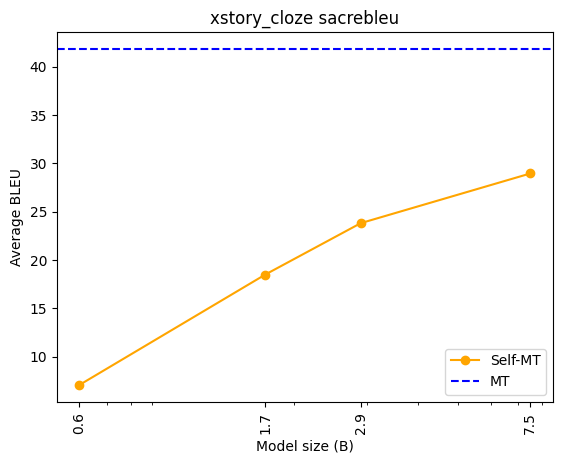

,et,ht,it,id,qu,sw,zh,ta,th,tr,vi,avg,model,size
nllb-200-3.3B,45.57,40.42,52.45,38.12,11.38,36.91,42.42,38.34,26.36,43.06,38.90,37.63,nllb,3.3
xglm-564M,12.08,9.37,10.06,12.99,0.35,2.96,0.92,2.29,7.67,4.62,8.73,6.55,xglm,0.6
xglm-1.7B,25.29,20.36,28.12,23.88,1.16,15.62,22.94,12.69,12.80,15.54,20.31,18.06,xglm,1.7
xglm-2.9B,34.93,25.21,32.88,27.51,1.91,21.70,29.21,17.77,22.52,22.32,29.36,24.12,xglm,2.9
xglm-7.5B,39.55,28.41,40.18,31.90,4.11,27.25,32.50,25.27,24.79,26.41,32.14,28.41,xglm,7.5


/tmp/ipykernel_460322/487229098.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


\begin{tabular}{lrrrrrrrrrrrrlr}
\toprule
{} &     et &     ht &     it &     id &     qu &     sw &     zh &     ta &     th &     tr &     vi &    avg & model &  size \\
\midrule
nllb-200-3.3B &  45.57 &  40.42 &  52.45 &  38.12 &  11.38 &  36.91 &  42.42 &  38.34 &  26.36 &  43.06 &  38.90 &  37.63 &  nllb &   3.3 \\
xglm-564M     &  12.08 &   9.37 &  10.06 &  12.99 &   0.35 &   2.96 &   0.92 &   2.29 &   7.67 &   4.62 &   8.73 &   6.55 &  xglm &   0.6 \\
xglm-1.7B     &  25.29 &  20.36 &  28.12 &  23.88 &   1.16 &  15.62 &  22.94 &  12.69 &  12.80 &  15.54 &  20.31 &  18.06 &  xglm &   1.7 \\
xglm-2.9B     &  34.93 &  25.21 &  32.88 &  27.51 &   1.91 &  21.70 &  29.21 &  17.77 &  22.52 &  22.32 &  29.36 &  24.12 &  xglm &   2.9 \\
xglm-7.5B     &  39.55 &  28.41 &  40.18 &  31.90 &   4.11 &  27.25 &  32.50 &  25.27 &  24.79 &  26.41 &  32.14 &  28.41 &  xglm &   7.5 \\
\bottomrule
\end{tabular}



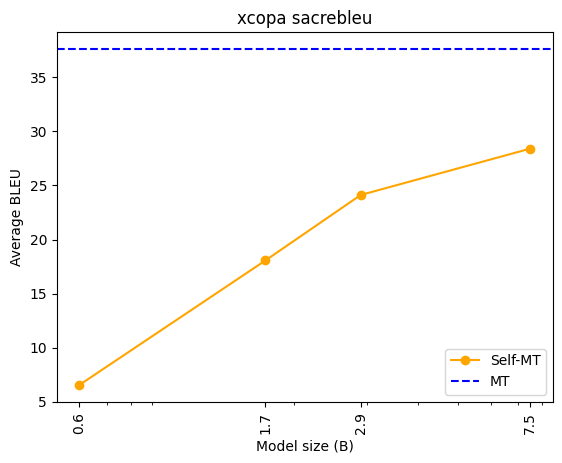

,ar,bg,de,el,es,fr,hi,ru,sw,th,tr,ur,vi,zh,avg,model,size
nllb-200-3.3B,42.19,45.08,47.66,50.05,53.80,47.73,41.73,33.98,37.89,31.35,40.61,33.86,43.20,31.31,41.46,nllb,3.3
xglm-564M,5.54,17.83,19.91,14.67,17.56,20.52,5.91,12.07,4.97,7.25,4.38,4.50,8.85,1.67,10.40,xglm,0.6
xglm-1.7B,16.34,27.20,30.30,30.86,31.54,29.73,12.77,18.83,16.63,15.23,11.78,9.81,21.11,12.36,20.32,xglm,1.7
xglm-2.9B,19.63,30.91,34.54,35.14,34.76,32.98,17.96,22.45,20.83,17.68,15.09,13.58,24.71,16.84,24.08,xglm,2.9
xglm-7.5B,26.52,35.23,38.80,39.16,41.56,38.93,22.09,25.91,26.29,22.56,19.71,17.61,29.08,19.80,28.80,xglm,7.5


\begin{tabular}{lrrrrrrrrrrrrrrrlr}
\toprule
{} &     ar &     bg &     de &     el &     es &     fr &     hi &     ru &     sw &     th &     tr &     ur &     vi &     zh &    avg & model &  size \\
\midrule
nllb-200-3.3B &  42.19 &  45.08 &  47.66 &  50.05 &  53.80 &  47.73 &  41.73 &  33.98 &  37.89 &  31.35 &  40.61 &  33.86 &  43.20 &  31.31 &  41.46 &  nllb &   3.3 \\
xglm-564M     &   5.54 &  17.83 &  19.91 &  14.67 &  17.56 &  20.52 &   5.91 &  12.07 &   4.97 &   7.25 &   4.38 &   4.50 &   8.85 &   1.67 &  10.40 &  xglm &   0.6 \\
xglm-1.7B     &  16.34 &  27.20 &  30.30 &  30.86 &  31.54 &  29.73 &  12.77 &  18.83 &  16.63 &  15.23 &  11.78 &   9.81 &  21.11 &  12.36 &  20.32 &  xglm &   1.7 \\
xglm-2.9B     &  19.63 &  30.91 &  34.54 &  35.14 &  34.76 &  32.98 &  17.96 &  22.45 &  20.83 &  17.68 &  15.09 &  13.58 &  24.71 &  16.84 &  24.08 &  xglm &   2.9 \\
xglm-7.5B     &  26.52 &  35.23 &  38.80 &  39.16 &  41.56 &  38.93 &  22.09 &  25.91 &  26.29 &  22.56 &  19.71 &  1

/tmp/ipykernel_460322/487229098.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


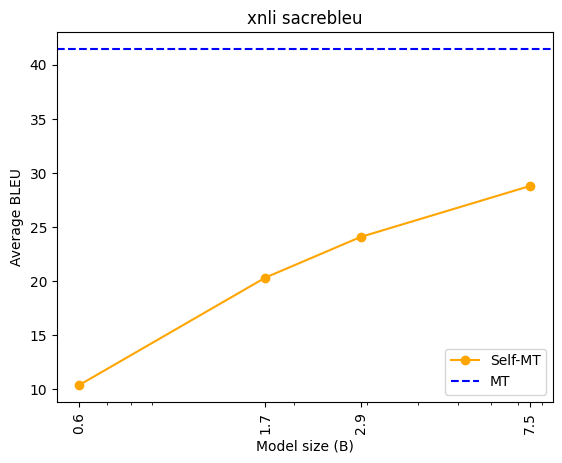

,de,es,fr,ja,ko,zh,avg,model,size
nllb-200-3.3B,61.19,66.02,62.91,38.12,41.97,41.21,51.90,nllb,3.3
xglm-564M,30.41,31.70,34.00,2.89,5.64,3.42,18.01,xglm,0.6
xglm-1.7B,44.35,47.33,43.03,9.13,14.64,11.34,28.30,xglm,1.7
xglm-2.9B,48.69,51.59,48.39,14.21,19.19,16.79,33.14,xglm,2.9
xglm-7.5B,51.22,54.58,53.12,18.27,24.89,20.09,37.03,xglm,7.5


/tmp/ipykernel_460322/487229098.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


\begin{tabular}{lrrrrrrrlr}
\toprule
{} &     de &     es &     fr &     ja &     ko &     zh &    avg & model &  size \\
\midrule
nllb-200-3.3B &  61.19 &  66.02 &  62.91 &  38.12 &  41.97 &  41.21 &  51.90 &  nllb &   3.3 \\
xglm-564M     &  30.41 &  31.70 &  34.00 &   2.89 &   5.64 &   3.42 &  18.01 &  xglm &   0.6 \\
xglm-1.7B     &  44.35 &  47.33 &  43.03 &   9.13 &  14.64 &  11.34 &  28.30 &  xglm &   1.7 \\
xglm-2.9B     &  48.69 &  51.59 &  48.39 &  14.21 &  19.19 &  16.79 &  33.14 &  xglm &   2.9 \\
xglm-7.5B     &  51.22 &  54.58 &  53.12 &  18.27 &  24.89 &  20.09 &  37.03 &  xglm &   7.5 \\
\bottomrule
\end{tabular}



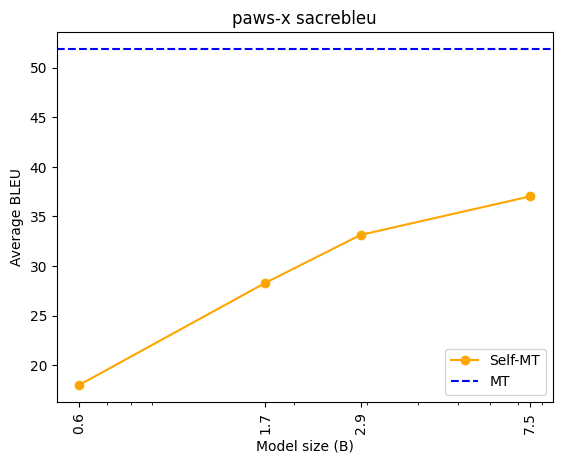

,es,fr,de,ru,zh,ja,th,sw,bn,te,avg,model,size
nllb-200-3.3B,57.91,44.26,53.41,44.85,38.44,35.59,24.30,51.37,42.89,44.02,43.70,nllb,3.3
xglm-564M,12.94,11.30,15.94,7.53,1.77,0.82,1.22,1.27,0.77,0.60,5.42,xglm,0.6
xglm-1.7B,36.77,24.31,33.33,23.89,8.26,6.14,9.32,16.76,5.43,6.50,17.07,xglm,1.7
xglm-2.9B,44.50,32.70,40.77,33.20,13.25,14.41,10.71,24.70,11.80,9.28,23.53,xglm,2.9
xglm-7.5B,45.04,33.37,41.55,34.70,20.75,20.09,18.44,31.32,19.11,18.63,28.30,xglm,7.5


/tmp/ipykernel_460322/487229098.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


\begin{tabular}{lrrrrrrrrrrrlr}
\toprule
{} &     es &     fr &     de &     ru &     zh &     ja &     th &     sw &     bn &     te &    avg & model &  size \\
\midrule
nllb-200-3.3B &  57.91 &  44.26 &  53.41 &  44.85 &  38.44 &  35.59 &  24.30 &  51.37 &  42.89 &  44.02 &  43.70 &  nllb &   3.3 \\
xglm-564M     &  12.94 &  11.30 &  15.94 &   7.53 &   1.77 &   0.82 &   1.22 &   1.27 &   0.77 &   0.60 &   5.42 &  xglm &   0.6 \\
xglm-1.7B     &  36.77 &  24.31 &  33.33 &  23.89 &   8.26 &   6.14 &   9.32 &  16.76 &   5.43 &   6.50 &  17.07 &  xglm &   1.7 \\
xglm-2.9B     &  44.50 &  32.70 &  40.77 &  33.20 &  13.25 &  14.41 &  10.71 &  24.70 &  11.80 &   9.28 &  23.53 &  xglm &   2.9 \\
xglm-7.5B     &  45.04 &  33.37 &  41.55 &  34.70 &  20.75 &  20.09 &  18.44 &  31.32 &  19.11 &  18.63 &  28.30 &  xglm &   7.5 \\
\bottomrule
\end{tabular}



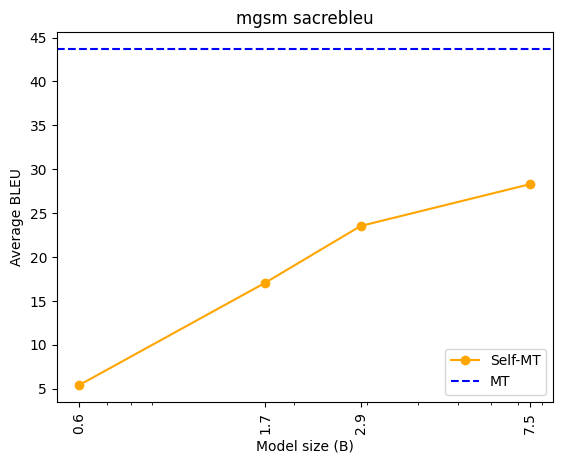

/tmp/ipykernel_460322/487229098.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_avg["avg"] = df_avg.mean(axis=1).round(1)


,model,xstory_cloze,xcopa,xnli,paws-x,mgsm,avg,size
nllb-200-3.3B,nllb,41.83,37.63,41.46,51.90,43.70,43.3,3.3
xglm-564M,xglm,7.08,6.55,10.40,18.01,5.42,9.5,0.6
xglm-1.7B,xglm,18.50,18.06,20.32,28.30,17.07,20.4,1.7
xglm-2.9B,xglm,23.81,24.12,24.08,33.14,23.53,25.7,2.9
xglm-7.5B,xglm,28.95,28.41,28.80,37.03,28.30,30.3,7.5


/tmp/ipykernel_460322/487229098.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_avg.to_latex(index=False))


\begin{tabular}{lrrrrrrr}
\toprule
model &  xstory\_cloze &  xcopa &  xnli &  paws-x &  mgsm &  avg &  size \\
\midrule
 nllb &         41.83 &  37.63 & 41.46 &   51.90 & 43.70 & 43.3 &   3.3 \\
 xglm &          7.08 &   6.55 & 10.40 &   18.01 &  5.42 &  9.5 &   0.6 \\
 xglm &         18.50 &  18.06 & 20.32 &   28.30 & 17.07 & 20.4 &   1.7 \\
 xglm &         23.81 &  24.12 & 24.08 &   33.14 & 23.53 & 25.7 &   2.9 \\
 xglm &         28.95 &  28.41 & 28.80 &   37.03 & 28.30 & 30.3 &   7.5 \\
\bottomrule
\end{tabular}



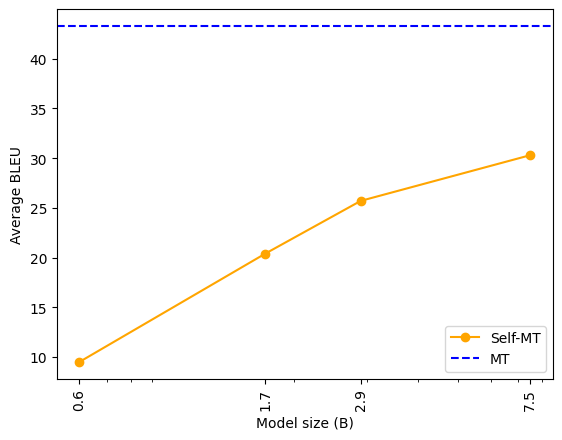

In [11]:
# create plots for each dataset and model

import matplotlib.pyplot as plt
import pandas as pd

def get_dataframes_model(model_name):
    for metric in ["sacrebleu"]: # ["sacrebleu", "chrf++", "comet"]
        df_avg = pd.DataFrame({"model": _MODELS}, index=_MODELS)
        for dataset_name in metrics_dict_split[metric]:
            df = pd.DataFrame(metrics_dict_split[metric][dataset_name]).T
            df_avg[dataset_name] = df["avg"]
            df["model"] = model_names_all
            df["size"] = model_sizes_all
            display(df)
            print(df.to_latex())
            # x labels vertical
            plot_size_df_datasets(df, model_name, f"{dataset_name} {metric}")
        df_avg["avg"] = df_avg.mean(axis=1).round(1)
        df_avg["model"] = model_names_all
        df_avg["size"] = model_sizes_all
        display(df_avg)
        print(df_avg.to_latex(index=False))
        plot_size_df_datasets(df_avg, model_name, title="")

get_dataframes_model("xglm")